In [16]:
import pandas as pd
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from IPython.display import Image 

In [17]:
# Store SN1_SN2 file as df (data frame)

CSV_PATH = "SN1_SN2_Mechanisms.csv"
MODEL_PATH = "reaction-mechanism-predictor.joblib"
FEATURES_PATH = "model_features.joblib"

df = pd.read_csv(CSV_PATH)

# Encode categorical columns 

# Map strength of nucleophile numerically
df['nucleophile_strength'] = df['nucleophile_strength'].map({'strong': 2, 'moderate': 1, 'weak': 0}) 

# Map SN1 and SN2 to 1 and 0
df['mechanism'] = df['mechanism'].map({'SN1': 1, 'SN2': 0})

# Get_dummies organizes remaining categories randomly with binary numbers
df = pd.get_dummies(df, columns = ['substrate_degree', 'special_environment', 'solvent', 'leaving_group'])

df.dropna(inplace = True)
X = df.drop(columns = ['mechanism', 'source'])
y = df['mechanism']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

joblib.dump(model, MODEL_PATH)
joblib.dump(X_train.columns.tolist(), FEATURES_PATH)

# Prediction accuracy
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"Test set accuracy: {acc:.2%}")

# Cross validation 
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f"Cross-validation accuracy: {scores.mean():.2%} ± {scores.std():.2%}")

# Pairwise coorelation 
corrs = df.corr(numeric_only = True)['mechanism'].sort_values(ascending = False)
print(corrs)

Test set accuracy: 100.00%
Cross-validation accuracy: 100.00% ± 0.00%
mechanism                       1.000000
solvent_protic                  0.952501
substrate_degree_tertiary       0.651920
special_environment_none        0.274873
leaving_group_Cl                0.223723
leaving_group_Br                0.155380
leaving_group_I                -0.058106
substrate_degree_secondary     -0.070340
substrate_degree_methyl        -0.134080
special_environment_benzylic   -0.144381
leaving_group_OTs              -0.175075
leaving_group_OTf              -0.192897
special_environment_allylic    -0.225374
leaving_group_OMs              -0.225374
substrate_degree_primary       -0.395554
nucleophile_strength           -0.722860
solvent_aprotic                -0.952501
Name: mechanism, dtype: float64


In [19]:
model = joblib.load(MODEL_PATH)
model_features = joblib.load(FEATURES_PATH)

In [21]:
allowed_conditions = {
    'substrate_degree': ['methyl', 'primary', 'secondary', 'tertiary'],
    'special_environment': ['none', 'allylic', 'benzylic', 'neopentyl'],
    'nucleophile_strength': ['strong', 'moderate', 'weak'],
    'solvent': ['protic', 'aprotic'],
    'leaving_group': ['h2o', 'br', 'cl', 'i', 'ots', 'oms', 'otf', 'F', 'TsO']
}
fields = {
    'substrate_degree': "Substrate degree (methyl, primary, secondary, tertiary): ",
    'special_environment': "Special environment (none, allylic, benzylic, neopentyl): ",
    'nucleophile_strength': "Nucleophile strength (strong, moderate, weak)" ,
    'solvent': "Solvent type (protic, aprotic): ",
    'leaving_group': "Leaving group: "
}
input_data = {}
for key, prompt in fields.items():
    while True:
        conditions = input(prompt).strip().lower()
        allowed = allowed_conditions.get(key)
        if allowed is None or conditions in allowed:
            input_data[key] = conditions
            break
        elif conditions.lower() == 'f':
            print("Fluorine is a poor leaving group due to it's highly electrophilic properties. Only in rare cases, such as halopyridine aromatic subsitutions does it function as a leaving group.")
        else:
            print(f"Invalid input for {key}. Allowed reaction conditions are: {allowed}")

Substrate degree (methyl, primary, secondary, tertiary):  methyl
Special environment (none, allylic, benzylic, neopentyl):  none
Nucleophile strength (strong, moderate, weak) strong
Solvent type (protic, aprotic):  aprotic
Leaving group:  i


In [22]:
nuc_map = {'strong': 2, 'moderate': 1, 'weak': 0}
input_data['nucleophile_strength'] = nuc_map[input_data['nucleophile_strength']]
df_input = pd.DataFrame([input_data])

df_input_encoded = pd.get_dummies(df_input, columns = ['substrate_degree', 'special_environment', 'solvent', 'leaving_group'])
# Assigns 0 to unused columns to fit model
for col in model_features:
    if col not in df_input_encoded.columns:
        df_input_encoded[col] = 0

# Rearranges columns in correct order
df_input_encoded = df_input_encoded[model_features]

Predicted mechanism: SN2


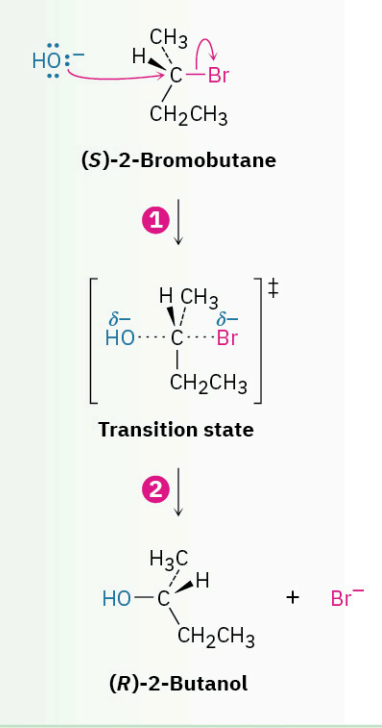

McMurry, Organic Chemistry: A Tenth Edition

 SN2 reactions occur in a single step and are dependent on 
 alkyl halide and leaving group concentrations. 
 As the nucleophile binds to a carbon atom on one side, 
 the leaving group departs on another side. 
 Non-bulky substrates and aprotic solvents favor SN2. 
 Protic solvents tend to decrease SN2 reaction rates due to solvation of the nucleophile. 
 While, aprotic solvents increase reaction rate by solvation of the neighboring cation. 



In [27]:
decode_map = {1: 'SN1', 0: 'SN2'}

# Gives first predicted value
prediction = model.predict(df_input_encoded)[0]
predicted_label = decode_map[prediction]
print("Predicted mechanism:", predicted_label)

def generate_explanation(predicted_label, substrate, nucleophile_strength, solvent, leaving_group):
    if predicted_label == 'SN2':
        return (f" SN2 reactions occur in a single step and are dependent on \n"
                f" alkyl halide and leaving group concentrations. \n"
                f" As the nucleophile binds to a carbon atom on one side, \n"
                f" the leaving group departs on another side. \n"
                f" Non-bulky substrates and {solvent} solvents favor SN2. \n"
                f" Protic solvents tend to decrease SN2 reaction rates due to solvation of the nucleophile. \n"
                f" While, aprotic solvents increase reaction rate by solvation of the neighboring cation. \n")
    elif predicted_label == 'SN1':
        return (f" SN1 reactions are first order reactions and have a \n carbocation intermediate. \n"
                f" This reaction is favored when a stable carbocation is formed. \n"
                f" Bulkier substrates increase SN1 reactivity. \n"
                f" Protic solvents favor carbocation formation. \n"
                f" SN1 reaction rates are not affected by nucleophiles as they are not in the rate limiting step.")
    else:
        return "Prediction unknown, unable to generate explanation."
        
def generate_image():
    if predicted_label == 'SN2':
        display(Image(filename = "SN2.png"))
        print("McMurry, Organic Chemistry: A Tenth Edition")
    
    elif predicted_label == 'SN1':
        display(Image(filename = "SN1.png")) 
        print("McMurry, Organic Chemistry: A Tenth Edition")

# Generate explanation based on users input
explanation_text = generate_explanation(
    predicted_label,
    input_data['substrate_degree'],
    input_data['nucleophile_strength'],
    input_data['solvent'],
    input_data['leaving_group']
)

generate_image()
print("\n" + explanation_text)